In [ ]:
from google.colab import files
uploaded = files.upload()


Saving URL dataset.csv to URL dataset.csv


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("URL dataset.csv")

# Preview first 5 rows
print(df.head())

# Check structure (columns, datatypes, nulls)
print(df.info())

# Check class distribution (legit vs phishing counts)
print(df['label'].value_counts())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Basic stats
print("\nDataset shape:", df.shape)

# Unique labels
print("\nUnique classes:", df['label'].unique())



                         url        type
0     https://www.google.com  legitimate
1    https://www.youtube.com  legitimate
2   https://www.facebook.com  legitimate
3      https://www.baidu.com  legitimate
4  https://www.wikipedia.org  legitimate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   type    450176 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB
None


KeyError: 'label'

In [ ]:
# Count phishing vs legitimate
print(df['type'].value_counts())


type
legitimate    345738
phishing      104438
Name: count, dtype: int64


In [ ]:
# Drop duplicates
df = df.drop_duplicates()

# Reset index
df = df.reset_index(drop=True)

# Check again
print("Shape after cleaning:", df.shape)
print(df['type'].value_counts())


Shape after cleaning: (450176, 2)
type
legitimate    345738
phishing      104438
Name: count, dtype: int64


In [ ]:
# Feature: URL length
df['url_length'] = df['url'].apply(len)

# Feature: Number of dots
df['num_dots'] = df['url'].apply(lambda x: x.count('.'))

# Feature: Top-Level Domain (TLD) like .com, .org, .ru
df['tld'] = df['url'].str.split('.').str[-1].str.split('/').str[0]

# Feature: Suspicious characters (@, -, =, _, ?)
suspicious_chars = ['@','-','=','_','?']
for char in suspicious_chars:
    df[f'count_{char}'] = df['url'].apply(lambda x: x.count(char))


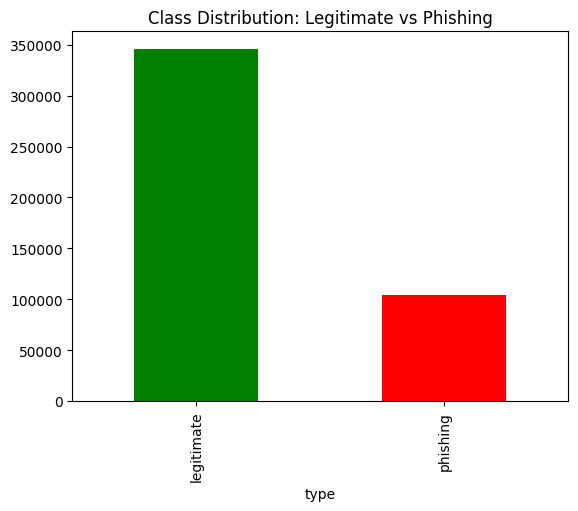

In [ ]:
import matplotlib.pyplot as plt

df['type'].value_counts().plot(kind='bar', color=['green','red'])
plt.title("Class Distribution: Legitimate vs Phishing")
plt.show()


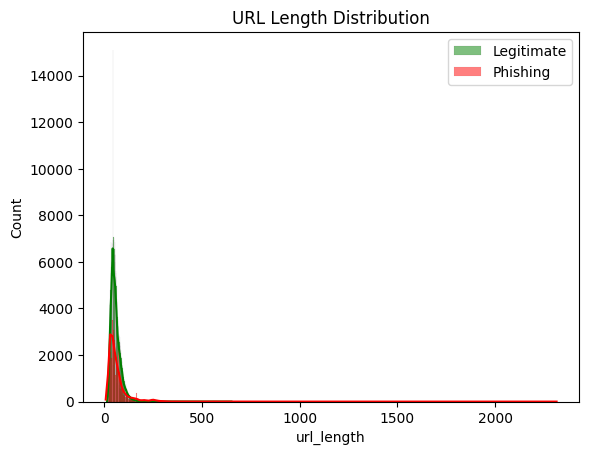

In [ ]:
import seaborn as sns

sns.histplot(df[df['type']=='legitimate']['url_length'], color='green', label='Legitimate', kde=True)
sns.histplot(df[df['type']=='phishing']['url_length'], color='red', label='Phishing', kde=True)
plt.legend()
plt.title("URL Length Distribution")
plt.show()


In [ ]:
print(df.groupby('type')['tld'].value_counts().groupby(level=0).head(10))


type        tld 
legitimate  com     177845
            html     51530
            org      24062
            htm      19158
            net       5763
            php       5154
            ca        5132
            aspx      5062
            edu       3201
            uk        2946
phishing    com      27393
            php      14767
            html      8046
            htm       4104
            net       3859
                      2648
            org       1812
            br        1715
            exe       1644
            ru        1341
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert 'legitimate' -> 0, 'phishing' -> 1
le = LabelEncoder()
df['label'] = le.fit_transform(df['type'])

print(df[['type','label']].head())


         type  label
0  legitimate      0
1  legitimate      0
2  legitimate      0
3  legitimate      0
4  legitimate      0


In [ ]:
from sklearn.model_selection import train_test_split

X = df['url']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 360140
Test size: 90036


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Character-level tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Convert URLs to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad to same length
maxlen = 200   # trim/pad URLs to 200 chars
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

print("Shape of X_train:", X_train_pad.shape)


Shape of X_train: (360140, 200)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Parameters
vocab_size = len(tokenizer.word_index) + 1   # total unique characters
embedding_dim = 128
maxlen = 200  # same as padding

# Model
model = Sequential()

# Embedding layer: turns chars → dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

# CNN layer: extract local patterns (like ".com", "http", etc.)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer: capture sequential patterns
model.add(LSTM(64, return_sequences=False))

# Fully connected layers
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binary classification

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=512,
    validation_data=(X_test_pad, y_test)
)


Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.9176 - loss: 0.2358 - val_accuracy: 0.9958 - val_loss: 0.0227
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9958 - loss: 0.0240 - val_accuracy: 0.9959 - val_loss: 0.0164
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9958 - loss: 0.0180 - val_accuracy: 0.9962 - val_loss: 0.0142
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.9962 - loss: 0.0153 - val_accuracy: 0.9967 - val_loss: 0.0132
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9963 - loss: 0.0149 - val_accuracy: 0.9968 - val_loss: 0.0125


2814/2814 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Classification Report:

              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69148
    phishing       1.00      0.99      0.99     20888

    accuracy                           1.00     90036
   macro avg       1.00      0.99      1.00     90036
weighted avg       1.00      1.00      1.00     90036



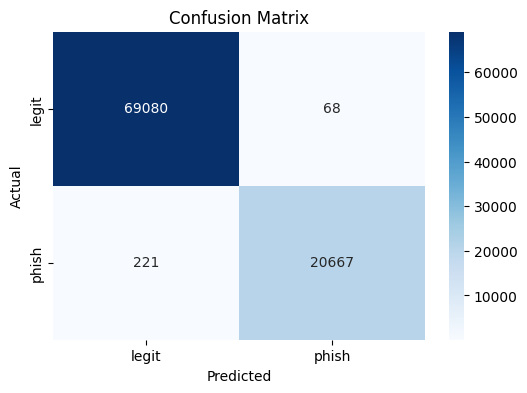

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test data
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype("int32")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["legitimate", "phishing"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["legit","phish"], yticklabels=["legit","phish"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


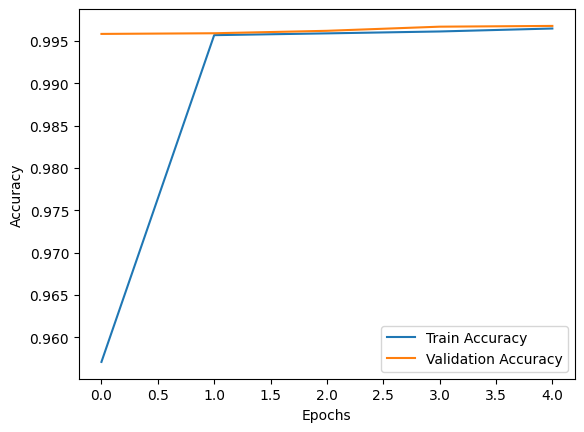

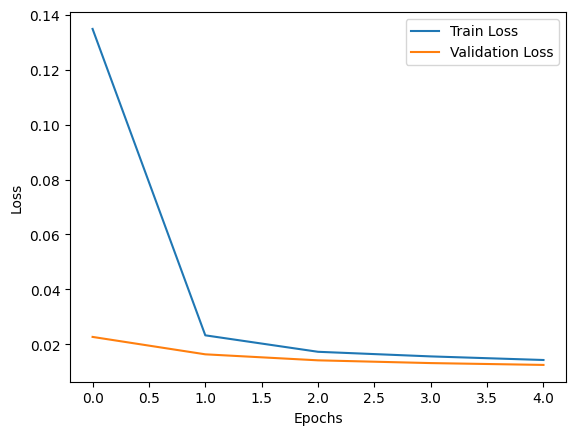

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Function to predict if a URL is phishing or legitimate
def predict_url(url):
    # Convert to sequence
    seq = tokenizer.texts_to_sequences([url])
    # Pad to same length as training
    padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    # Predict
    pred = model.predict(padded)[0][0]

    # Threshold 0.5 → phishing vs legit
    if pred >= 0.5:
        print(f"🔴 Phishing URL detected ({pred:.2f} confidence)")
    else:
        print(f"🟢 Legitimate URL ({1-pred:.2f} confidence)")

# --- Try with custom examples ---
predict_url("http://free-gift-login.com")  # should be phishing
predict_url("https://www.google.com")     # should be legitimate
predict_url("https://secure-update-paypal.com/login")  # likely phishing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
🔴 Phishing URL detected (0.92 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
🔴 Phishing URL detected (0.92 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
🔴 Phishing URL detected (0.92 confidence)


In [ ]:
from sklearn.utils import resample

# Separate
df_legit = df[df['type'] == 'legitimate']
df_phish = df[df['type'] == 'phishing']

# Downsample legitimate to match phishing count
df_legit_bal = resample(df_legit, replace=False, n_samples=len(df_phish), random_state=42)

# Merge balanced dataset
df_balanced = pd.concat([df_legit_bal, df_phish])

print(df_balanced['type'].value_counts())


type
legitimate    104438
phishing      104438
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Use df_balanced instead of df
X_bal = df_balanced['url'].values
y_bal = df_balanced['type'].map({'legitimate':0, 'phishing':1}).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 50000
maxlen = 200

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)

# Model (recreate same as before)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(max_words, 128, input_length=maxlen),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train longer (10 epochs)
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(X_test_pad, y_test),
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


327/327 ━━━━━━━━━━━━━━━━━━━━ 249s 745ms/step - accuracy: 0.9625 - loss: 0.1557 - val_accuracy: 0.9967 - val_loss: 0.0122
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 234s 665ms/step - accuracy: 0.9975 - loss: 0.0097 - val_accuracy: 0.9974 - val_loss: 0.0098
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 262s 665ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9977 - val_loss: 0.0100
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 261s 662ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9975 - val_loss: 0.0106
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 218s 667ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9977 - val_loss: 0.0107
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 263s 669ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9972 - val_loss: 0.0124
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 261s 668ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9976 - val_loss: 0.0121
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 261s 665ms/step - accuracy: 0.9991 - loss: 0.00

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred, target_names=['Legitimate','Phishing']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


1306/1306 ━━━━━━━━━━━━━━━━━━━━ 145s 111ms/step
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     20888
    Phishing       1.00      1.00      1.00     20888

    accuracy                           1.00     41776
   macro avg       1.00      1.00      1.00     41776
weighted avg       1.00      1.00      1.00     41776

Confusion Matrix:
 [[20854    34]
 [   70 20818]]


In [ ]:
# Save model
model.save("phish_model.h5")
print("✅ Model saved as phish_model.h5")

# Save tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as tokenizer.pkl")


In [ ]:
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Load model
model = load_model("phish_model.h5")

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Define maxlen (must be SAME as training)
MAXLEN = 200   # change if your training used different

# Example test
test_urls = ["https://paypal-login.com", "https://www.google.com"]

# Tokenize & pad
test_seq = pad_sequences(tokenizer.texts_to_sequences(test_urls), maxlen=MAXLEN)

# Predictions
preds = model.predict(test_seq)

for url, score in zip(test_urls, preds):
    label = "Phishing ❌" if score > 0.5 else "Legitimate ✅"
    print(f"{url} → {label} (Confidence: {float(score):.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
https://paypal-login.com → Phishing ❌ (Confidence: 1.00)
https://www.google.com → Legitimate ✅ (Confidence: 0.00)


/tmp/ipython-input-3470195955.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{url} → {label} (Confidence: {float(score):.2f})")


In [ ]:
# Example URLs
test_urls = [
    "www.amazon.com",
    "www.linkedin.com",
    "paypal-login-secure.com",
    "www.paypal.com.secure-login.info",
    "www.google.com"
]

# Tokenize & pad
test_seq = pad_sequences(tokenizer.texts_to_sequences(test_urls), maxlen=maxlen)

# Predict
pred_probs = model.predict(test_seq)
pred_labels = (pred_probs > 0.5).astype("int32")

# Print results
for url, prob, label in zip(test_urls, pred_probs, pred_labels):
    status = "Phishing" if label[0]==1 else "Legitimate"
    print(f"{url} --> {status} ({prob[0]:.2f} confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
www.amazon.com --> Legitimate (0.19 confidence)
www.linkedin.com --> Legitimate (0.15 confidence)
paypal-login-secure.com --> Phishing (1.00 confidence)
www.paypal.com.secure-login.info --> Phishing (1.00 confidence)
www.google.com --> Legitimate (0.50 confidence)


In [ ]:
from google.colab import files
files.download("phish_model.h5")
files.download("tokenizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>